## feature ranking with elimination

In [1]:
import csv
import time  # Just to compare fit times
from pathlib import Path
from pprint import pprint
import csv
import multiprocessing

In [1]:
import numpy as np
# import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import xgboost as xgb
# from tune_sklearn import TuneSearchCV
# from xgboost import XGBRegressor
# import xgboost as xgb

In [ ]:
import pandas as pd
import numpy as np
import distributed

import dask
import dask.array as da
import dask.dataframe as dd
from dask.distributed import Client, wait, LocalCluster

from dask_cuda import LocalCUDACluster
from sklearn.model_selection import train_test_split

# from dask_ml.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
# from dask_ml.metrics import r2_score
import xgboost as xgb

In [4]:
input_dataset_path = Path('../data/input_dataset.csv')

## Build-in Recursive feature elimination with cross-validation


Optimal number of features : 35


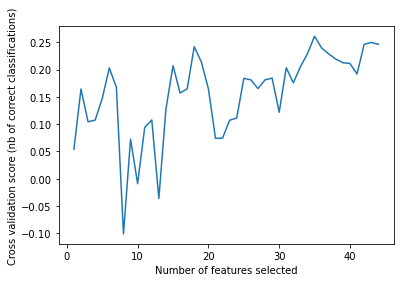

CPU times: user 10min 20s, sys: 12.5 s, total: 10min 33s
Wall time: 2min 43s


In [9]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV


# Create the RFE object and compute a cross-validated score.
xgb_model = xgb.XGBRegressor(n_jobs=multiprocessing.cpu_count() // 2)

# The "accuracy" scoring is proportional to the number of correct
# classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=xgb_model, 
              step=1, 
              cv=2,
              scoring='r2',
              min_features_to_select=min_features_to_select)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)


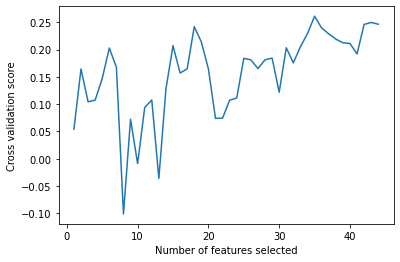

In [13]:

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select), rfecv.grid_scores_)
plt.show()

In [14]:
rfecv.support_

array([ True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True, False, False,  True, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True, False,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [15]:
rfecv.ranking_

array([ 1,  1,  1,  1,  1,  1,  5,  8,  1,  1,  1,  4,  3,  1,  9,  1,  1,
        1,  1,  1,  7,  1,  1,  1,  1,  1,  1,  6,  1,  1, 10,  1,  1,  1,
        2,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [16]:
headers = next(csv.reader(open(input_dataset_path)))[1:]

unsorteddic = {}
for i, rank in enumerate(rfecv.ranking_):
        unsorteddic[headers[i]] = rank
sorteddic = dict(sorted(unsorteddic.items(), key=lambda item: item[1]))
sorteddic

{'/g/data/ge3/sheece/LOC_distance_to_coast.tif': 1,
 '/g/data/ge3/sheece/mrvbf_9.tif': 1,
 '/g/data/ge3/sheece/relief_mrvbf_3s_mosaic.tif': 1,
 '/g/data/ge3/sheece/relief_elev_focalrange1000m_3s.tif': 1,
 '/g/data/ge3/sheece/relief_elev_focalrange300m_3s.tif': 1,
 '/g/data/ge3/sheece/saga_wetSM_85_resampled.tif': 1,
 '/g/data/ge3/sheece/dem_fill.tif': 1,
 '/g/data/ge3/sheece/3dem_mag2.tif': 1,
 '/g/data/ge3/sheece/3dem_mag1_fin.tif': 1,
 '/g/data/ge3/sheece/Dose_2016.tif': 1,
 '/g/data/ge3/sheece/Potassium_2016.tif': 1,
 '/g/data/ge3/sheece/Thorium_2016.tif': 1,
 '/g/data/ge3/sheece/Rad2016U_Th.tif': 1,
 '/g/data/ge3/sheece/Rad2016K_Th.tif': 1,
 '/g/data/ge3/sheece/si_geol1.tif': 1,
 '/g/data/ge3/sheece/ceno_euc_aust1.tif': 1,
 '/g/data/ge3/sheece/Grav_lane_clip.tif': 1,
 '/g/data/ge3/sheece/be-30y-85m-avg-ND-NIR-GREEN.filled.lzw.nodata.tif': 1,
 '/g/data/ge3/sheece/be-30y-85m-avg-ND-SWIR1-SWIR2.filled.lzw.nodata.tif': 1,
 '/g/data/ge3/sheece/be-30y-85m-avg-ND-SWIR1-NIR.filled.lzw.noda

## In-house Recursive feature elimination

In [249]:
# # from sklearn.metrics import  explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

# # Start cluster and client. This is currently local, although I would like to make this distributed across many nodes.
# # cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES='0,1,2,3', threads_per_worker=2)
# cluster = LocalCluster(n_workers=24,threads_per_worker=12,dashboard_address='0.0.0.0:8787')
# # cluster = LocalCluster(dashboard_address='0.0.0.0:8787') # Workers: 6, Cores: 24
# # cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES='0,1,2,3', threads_per_worker=24,dashboard_address='0.0.0.0:8787')

# # cluster = LocalCUDACluster()
# client = Client(cluster)
# client

/home/dev/Desktop/Work/uncoverml/venv/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32853 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:44119 Dashboard: http://127.0.0.1:32853/status,Cluster Workers: 24 Cores: 288 Memory: 134.74 GB


In [ ]:
def get_score_without_feature(X, y, features_to_drop):
    
    dtrain = xgb.DMatrix(data=X.drop(features_to_drop,axis=1), label=y,nthread=-1)

    param = {
        'objective':'reg:squarederror',
        'tree_method':'approx',
        'predictor': 'cpu_predictor'
    }
    xgb_cv_results = xgb.cv(param, dtrain,nfold=3,metrics="rmsle",verbose_eval=False,seed=0)
    best_score = xgb_cv_results.iloc[:,0].values[-1]
    return best_score

In [250]:
def find_least_important_feature(X, y):
        
    intermediate_results = {}
    for featureindex,feature_name in enumerate(X.columns):
        score_without_feature = get_score_without_feature(X, y, feature_name)
        intermediate_results[feature_name] = score_without_feature
        print("Getting score for: ",feature_name,score_without_feature,len(X.columns)-1)
           
    # calculate the results        
    lowest_feature = None
    lowest_score = -999
    for feature_name in intermediate_results.keys():
        score_without_feature = intermediate_results[feature_name]
        if score_without_feature >= lowest_score:
            lowest_score = score_without_feature
            lowest_feature = feature_name
        del score_without_feature
    
    
    results = {}
    results["lowest_score"] = lowest_score
    results["lowest_feature"] = lowest_feature
    results["intermediate_results"] = intermediate_results
    return results

In [251]:


%%time

X = df.drop("target",axis=1)   # Feature Matrix
y = df["target"]    

min_features_required = 2
complete_result = {}
results = {}

current_total_feature = X.shape[1]
complete_result[current_total_feature] = {}

count = 1
print("Staring experiment for: ",X.shape[1]," features")
results[current_total_feature] = find_least_important_feature(X,y)
print("Results of ",str(count)," iteration:",results[current_total_feature]["lowest_score"],results[current_total_feature]["lowest_feature"])

current_X = X.drop(results[current_total_feature]["lowest_feature"],axis=1)   
current_total_feature = current_X.shape[1]

count = 2
while(current_total_feature>min_features_required):
    print("Staring experiment for: ",current_total_feature)
    results[current_total_feature] = find_least_important_feature(current_X,y)
    print("Results of ",str(count)," iteration:",results[current_total_feature]["lowest_score"],results[current_total_feature]["lowest_feature"])
    current_X = current_X.drop(results[current_total_feature]["lowest_feature"],axis=1)
    current_total_feature = current_X.shape[1]
    
    count = count + 1



In [254]:
# open a file, where you ant to store the data
file = open('../data/results_rfrcv', 'wb')

# dump information to that file
pickle.dump(results, file)

# close the file
file.close()



NotImplementedError: 'DataFrame.iloc' only supports selecting columns. It must be used like 'df.iloc[:, column_indexer]'.

In [126]:
plot_1_data = []
for exp_no in results.keys():
        plot_1_data.append((exp_no,results[exp_no]["lowest_score"]))

plt.scatter(*zip(*plot_1_data))
plt.gca().invert_xaxis()
plt.ylim(0,0.5)
plt.xlabel("Number of features in this experiment")
plt.ylabel("rmsle score for the weakest the feature")
plt.show()

[]

In [ ]:
#save results
import pickle

fileObj = open('complete_result_irfec.pkl', 'wb')
pickle.dump(complete_result,fileObj)
fileObj.close()

In [ ]:
## In-house Recursive feature elimination sci-kit style


## Shutdown Cluster

In [220]:
client = distributed.client._get_global_client()
client

Client Scheduler: tcp://127.0.0.1:34217 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 96 Memory: 538.97 GB


In [221]:
client.shutdown()


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
ERROR:asyncio:_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
